In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data Creation
path = "../input/price-volume-data-for-all-us-stocks-etfs/Stocks/googl.us.txt"
file = open(path)
columns = list(file.readline().strip().split(","))

data = []
for line in file.readlines():
    data.append(line.strip().split(","))

df = pd.DataFrame(data=data, columns=columns)
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50,52.03,47.98,50.17,44703800,0
1,2004-08-20,50.505,54.54,50.25,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.7,18274400,0
3,2004-08-24,55.62,55.8,51.785,52.435,15262600,0
4,2004-08-25,52.48,54,51.94,53,9197800,0


In [3]:
# Dropping unnecessary columns
data = df.reset_index()["Close"].astype("float32")
data.head()

0    50.169998
1    54.154999
2    54.700001
3    52.435001
4    53.000000
Name: Close, dtype: float32

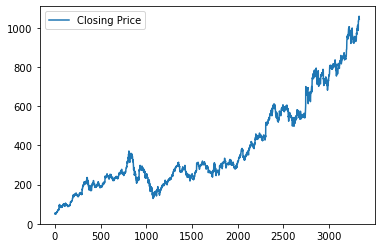

In [4]:
# Visualizing the closing price
try:
    sns.lineplot(data=data[:, 0], label="Closing Price")
except:
    sns.lineplot(data=data, label="Closing Price")

In [5]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))
print(data.shape)

(3333, 1)


In [6]:
# Splitting dataset into train and test split
train_size = int(len(data) * 0.65)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:], data[train_size:len(data), :1]
print(train_size, test_size)

2166 1167


In [7]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]    
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
# Preparing the dataset
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
# X and y shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2065, 100) (2065,)
(1066, 100) (1066,)


In [10]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)
print(X_train.shape, X_test.shape)

(2065, 100, 1) (1066, 100, 1)


In [11]:
# Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [12]:
# Model
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Run the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

Epoch 1/50
33/33 [==============================] - 8s 232ms/step - loss: 0.0061 - val_loss: 0.0701
Epoch 2/50
33/33 [==============================] - 6s 186ms/step - loss: 6.8936e-04 - val_loss: 0.0026
Epoch 3/50
33/33 [==============================] - 6s 187ms/step - loss: 2.4454e-04 - val_loss: 9.0126e-04
Epoch 4/50
33/33 [==============================] - 6s 179ms/step - loss: 2.3373e-04 - val_loss: 0.0010
Epoch 5/50
33/33 [==============================] - 6s 182ms/step - loss: 2.2872e-04 - val_loss: 8.2896e-04
Epoch 6/50
33/33 [==============================] - 6s 185ms/step - loss: 2.1716e-04 - val_loss: 7.8031e-04
Epoch 7/50
33/33 [==============================] - 6s 183ms/step - loss: 2.0790e-04 - val_loss: 6.5116e-04
Epoch 8/50
33/33 [==============================] - 6s 184ms/step - loss: 2.0292e-04 - val_loss: 9.0286e-04
Epoch 9/50
33/33 [==============================] - 6s 185ms/step - loss: 1.9765e-04 - val_loss: 7.9191e-04
Epoch 10/50
33/33 [=========================

In [14]:
# Predicting the results
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
results = np.concatenate((train_predict, test_predict), axis=0)

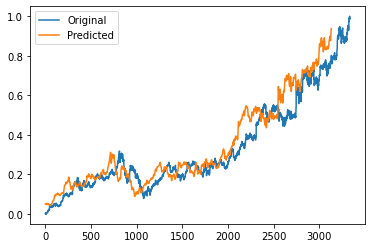

In [15]:
# Original vs Predicted
try:
    sns.lineplot(data=data[:, 0], label="Original")
    sns.lineplot(data=results[:, 0], label="Predicted")
except:
    sns.lineplot(data=data, label="Original")
    sns.lineplot(data=results, label="Predicted")